**Challenge context**

Elmy aimerait disposer d’un modèle de prévision permettant de juger en amont si les prix de l’électricité sur le marché SPOT (marché d’enchère européen permettant d’acheter de l’électricité la veille pour le lendemain) seront plus ou moins élevés que les prix de l’électricité sur le marché Intraday (marché boursier européen permettant d’acheter de l’électricité le jour même).

**Challenge goals**

L’exercice consiste en la modélisation supervisée de l'écart de prix entre le marché infra-journalier (dit "Intraday") et le marché SPOT. L'écart de prix peut être modélisé par une régression mais aussi par une classification car ce qui importe avant tout est de prédire correctement le sens de cet écart (si tel ou tel prix sera supérieur ou inférieur à l’autre).

**Data description**
* Index
>* DELIVERY_START : date et heure de livraison de l'électricité

* Variables explicatives
>* load_forecast : prévision de consommation totale d'éléctricité en France
>* coal_power_available, gas_power_available, nucelear_power_available : capacité de production totale d'électricité des centrales à charbon, gaz et nucléaire respectivement,
>* wind_power_forecasts_average, solar_power_forecasts_average : moyenne de différentes prévisions de production totale d'électricité éolienne et solaire (respectivement),
>* wind_power_forecasts_std, solar_power_forecasts_std : écart-type de ces mêmes prévisions,
>* predicted_spot_price : prévision du prix SPOT de l'électricité issues d'un modèle interne de Elmy. Ce modèle est lancé chaque jour avant la fermeture des enchères SPOT pour le lendemain.

* Variable cible
>* spot_id_delta : l'écart entre le VWAP des transactions sur le marché infra-journalier (Intraday) et le prix SPOT pour 1MWh d'électricité (spot_id_delta = Intraday - SPOT) : si la valeur est positive, le prix Intraday est supérieur au prix SPOT et inversement.

**Métrique d'évaluation des performances du modèle**

Puisque l'objectif est avant de tout de prédire correctement le sens de l'écart, on s'appuyera sur une métrique de classification pour évaluer la performance d'un modèle. La grandeur de l'écart observé nous importe aussi : plus l'écart observé est important, plus il est important de prédire le correctement son sens. La métrique de performance proposée pour ce challenge est donc la Weighted Accuracy. C'est à dire la proprotion des predictions dont les sens (positif ou négatif) est correctement identifié pondérée par la valeur absolue des écarts réellement observés

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib inline
import seaborn as sns
from datetime import datetime


In [2]:
x_train = pd.read_csv("data/x_train.csv", index_col= 'DELIVERY_START', parse_dates=True)
y_train = pd.read_csv("data/y_train.csv", index_col= 'DELIVERY_START', parse_dates=True)

x_test = pd.read_csv("data/x_test.csv", index_col= 'DELIVERY_START', parse_dates=True)

In [22]:
print(y_train.index.min().date())
print(y_train.index[0])
print(y_train.index[1])

2022-01-01
2022-01-01 02:00:00+01:00
2022-01-01 03:00:00+01:00


In [4]:
print(f"Training data : from {x_train.index.min().date()} to {x_train.index.max().date()}")
print(f"Test data : from {x_test.index.min().date()} to {x_test.index.max().date()}")

Training data : from 2022-01-01 to 2023-03-29
Test data : from 2023-04-02 to 2023-10-24


In [5]:
x_train.shape

(10605, 9)

In [6]:
x_test.shape

(4942, 9)

<Axes: ylabel='DELIVERY_START'>

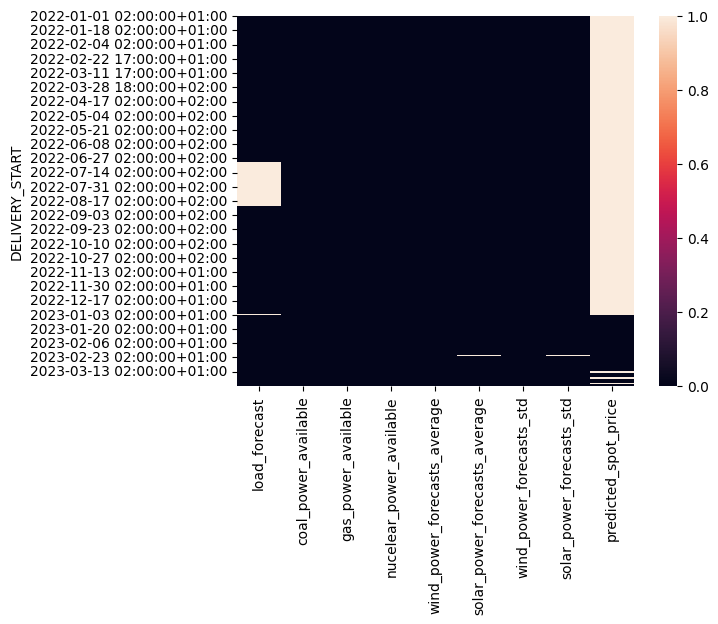

In [7]:
sns.heatmap(x_train.isna())

<Axes: ylabel='DELIVERY_START'>

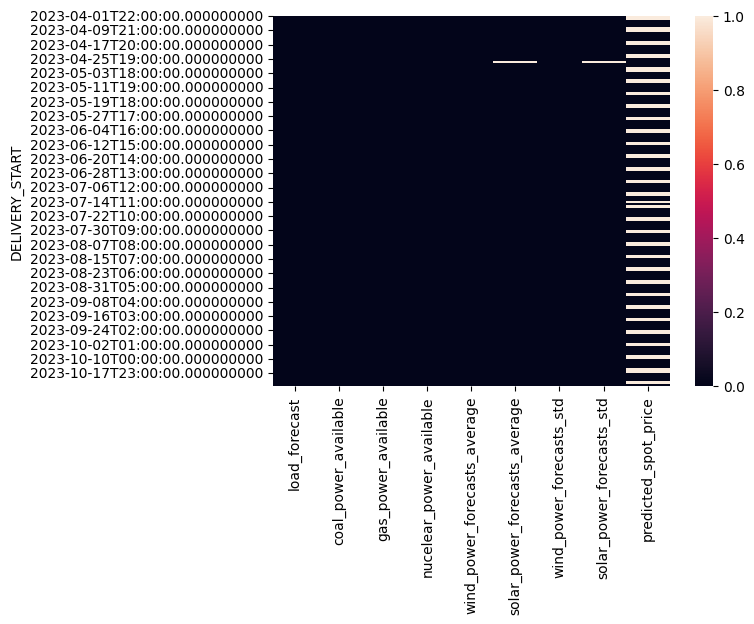

In [8]:
sns.heatmap(x_test.isna())

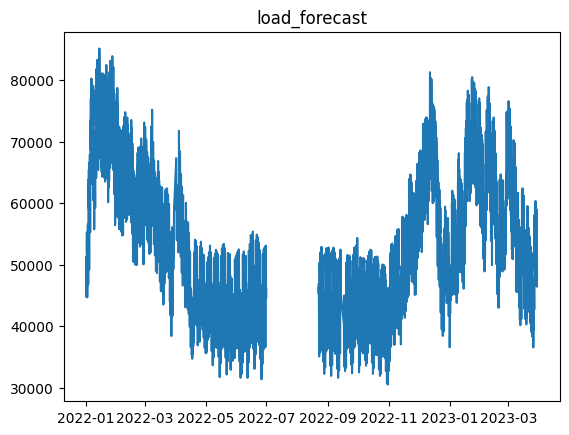

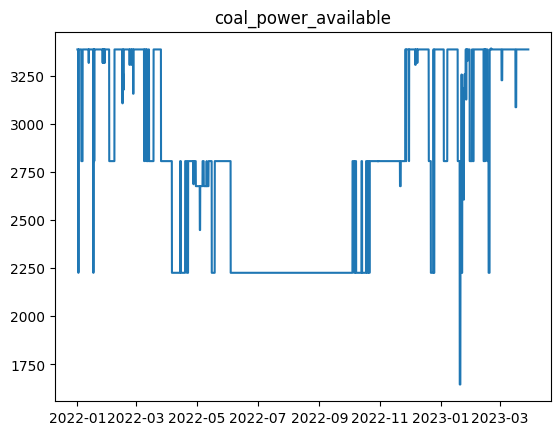

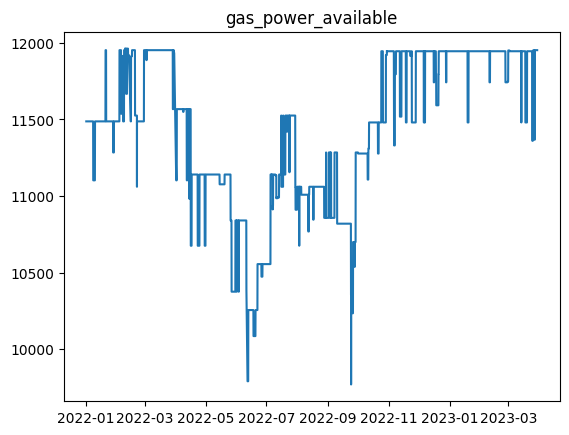

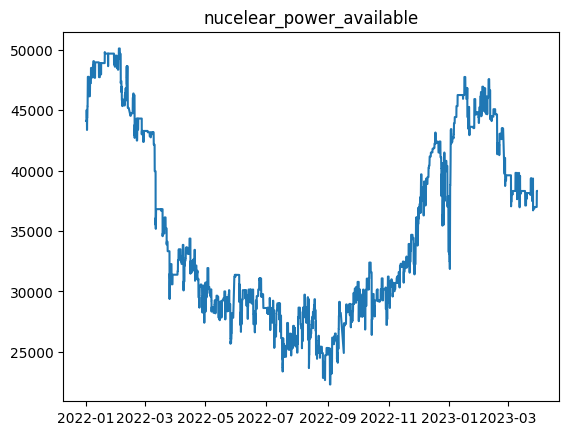

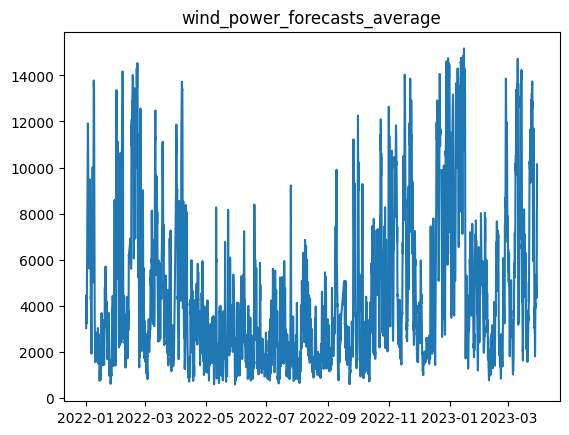

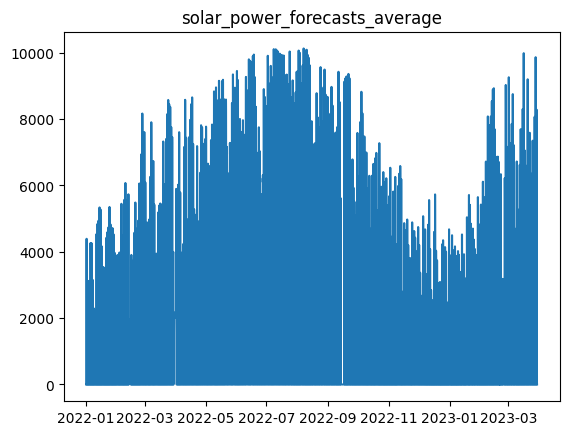

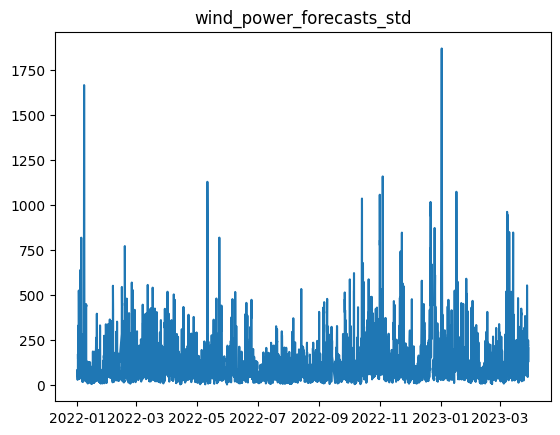

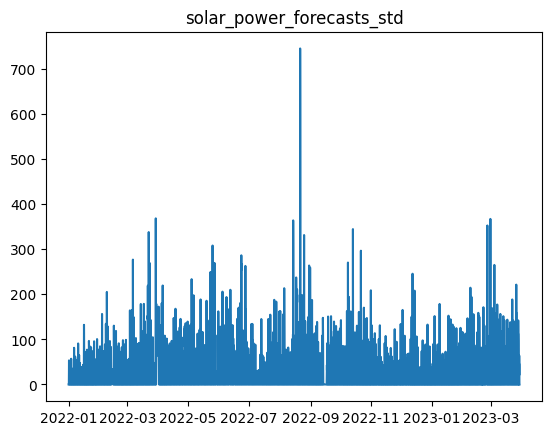

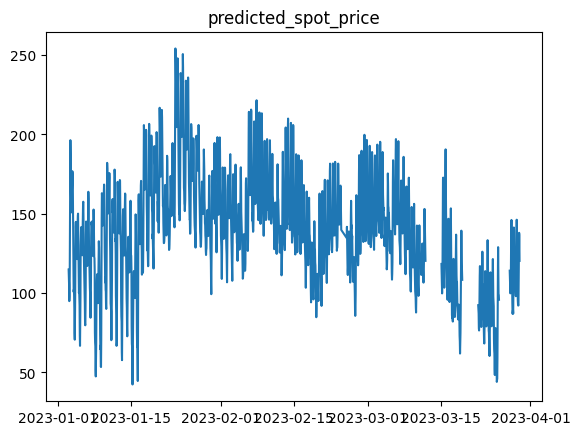

In [9]:
for col in x_train.columns:
    plt.plot(x_train.index, x_train[col], label=col)
    plt.title(col)
    plt.show()

Text(0.5, 1.0, 'spot_id_delta')

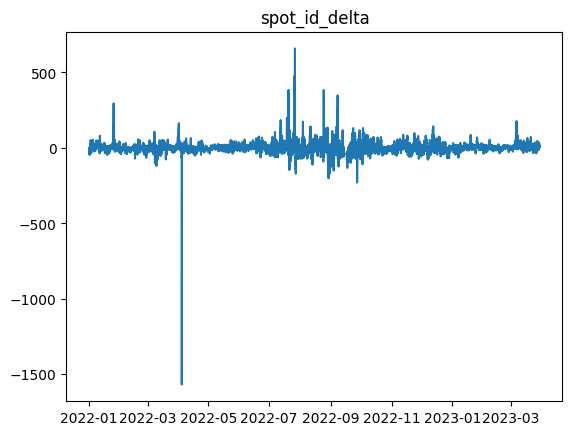

In [10]:
plt.plot(y_train.index, y_train['spot_id_delta'])
plt.title('spot_id_delta')

<Axes: >

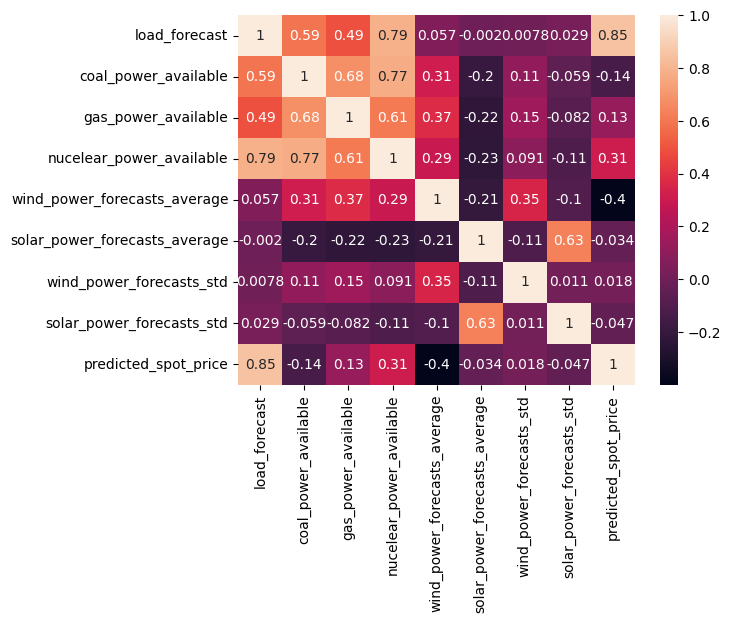

In [11]:
# Display correlation matrix
corr = x_train.corr()
sns.heatmap(corr, annot=True)


In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

x_train_scaled = pd.DataFrame(x_train_scaled, columns=x_train.columns, index=x_train.index)
x_test_scaled = pd.DataFrame(x_test_scaled, columns=x_test.columns, index=x_test.index)
x_train_scaled.drop(columns=['predicted_spot_price'], inplace=True)
x_test_scaled.drop(columns=['predicted_spot_price'], inplace=True)

x_train_scaled.fillna(method='ffill', inplace=True)
x_test_scaled.fillna(method='ffill', inplace=True)

x_train_scaled.head()


/tmp/ipykernel_89970/1422914570.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  x_train_scaled.fillna(method='ffill', inplace=True)
/tmp/ipykernel_89970/1422914570.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  x_test_scaled.fillna(method='ffill', inplace=True)


,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std
DELIVERY_START,,,,,,,,
2022-01-01 02:00:00+01:00,-0.380192,1.14369,0.049154,1.145057,-0.441288,-0.70905,-0.349241,-0.580229
2022-01-01 03:00:00+01:00,-0.639914,1.14369,0.049154,1.145057,-0.409042,-0.70905,-0.481457,-0.580229
2022-01-01 04:00:00+01:00,-0.759929,1.14369,0.049154,1.145057,-0.365749,-0.70905,-0.613775,-0.580229
2022-01-01 05:00:00+01:00,-0.793548,1.14369,0.049154,1.145057,-0.318276,-0.70905,-0.675551,-0.580229
2022-01-01 06:00:00+01:00,-0.748753,1.14369,0.049154,1.145057,-0.249007,-0.70905,-0.714482,-0.580229


<Axes: ylabel='DELIVERY_START'>

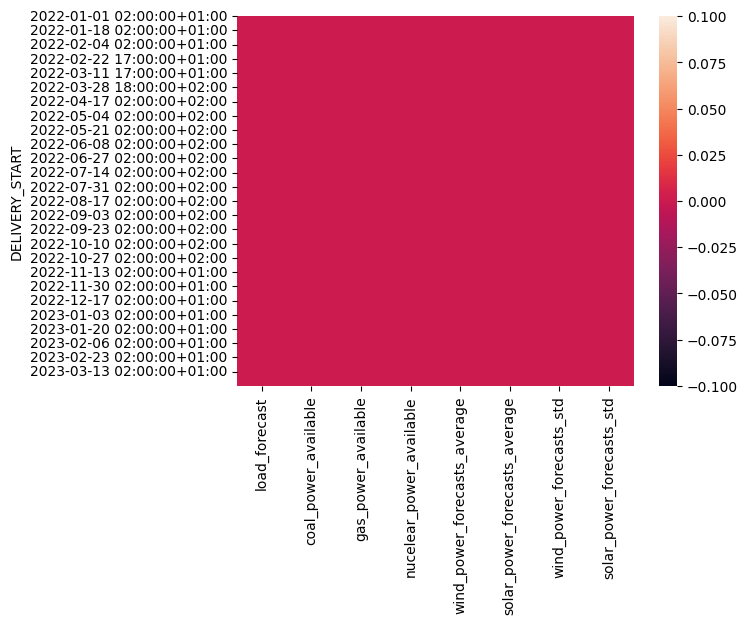

In [13]:
sns.heatmap(x_train_scaled.isna())

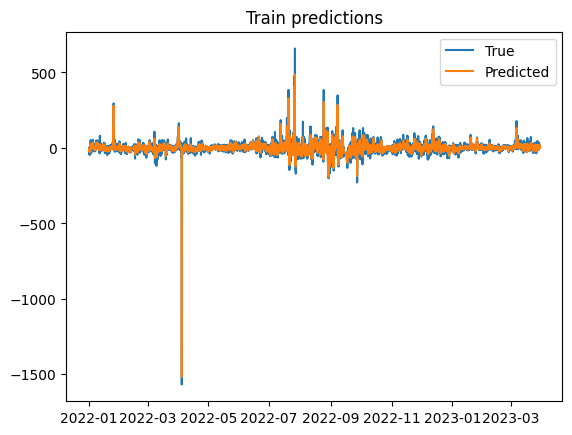

In [14]:
# Fit baseline model xgboost
from xgboost import XGBRegressor

model = XGBRegressor()

model.fit(x_train_scaled, y_train)
y_train_pred = model.predict(x_train_scaled)
y_test_pred = model.predict(x_test_scaled)


# Plot predictions
plt.plot(y_train.index, y_train, label='True')
plt.plot(y_train.index, y_train_pred, label='Predicted')
plt.title('Train predictions')
plt.legend()
plt.show()


In [15]:
from src.metrics import weighted_accuracy
score = weighted_accuracy(y_train, y_train_pred)
print(f"Score : {score}")

Score : 0.9357074860178076


/tmp/ipykernel_89970/2822485313.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  x_train['nucelear_power_available'].fillna(method='ffill', inplace=True)


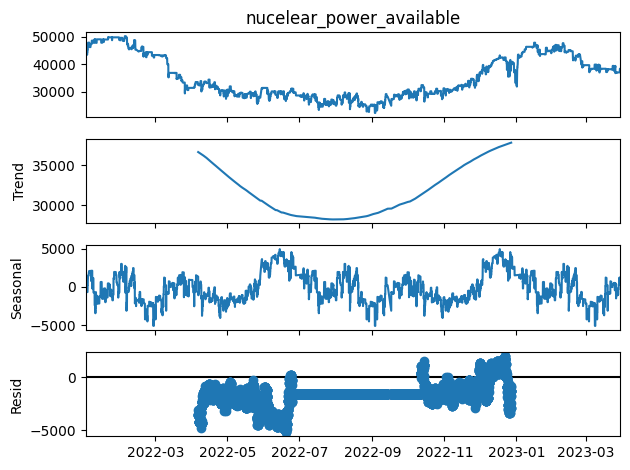

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose
x_train['nucelear_power_available'].fillna(method='ffill', inplace=True)
result = seasonal_decompose(x_train['nucelear_power_available'], model='additive', period=4380)
result.plot()
plt.show()